## 1. Import Libraries

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import cv2

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image


## 2. Import Model and Images

### 2.1 Import Model

In [4]:
model = load_model('../Models/segmentation_model.h5')

### 2.2 Import Images

In [7]:
# Load and preprocess the image
#img_path = 'Resources/images/img_0001.png'
#img_path = 'Resources/test_Images/test_image_001.png'  # Replace with the actual path to your image
img_path = 'Resources/test_Images/test_image_001.png'
img = load_img(img_path, target_size=(384,384))  # Replace height and width with your model's input size
img_array_org = img_to_array(img)
img_array = np.expand_dims(img_array_org, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image if required by your model

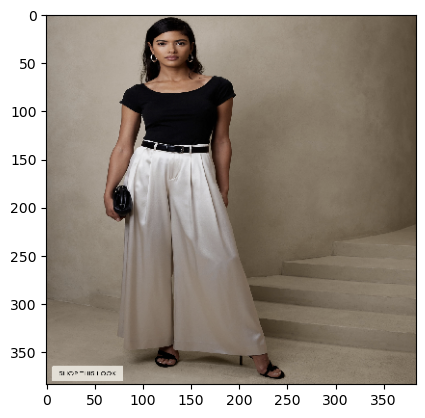

In [8]:
# Display image
plt.imshow(img)

## 3. Make Predictions

In [9]:
# Predict image mask
predicted_mask = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


In [10]:
# Get image mask shape
predicted_mask.shape

(1, 384, 384, 59)

In [11]:
# Use the squeeze fuction to change the image mask shape
predicted_mask = np.squeeze(predicted_mask, axis=0)
predicted_mask.shape

(384, 384, 59)

In [12]:
predicted_mask = np.argmax(predicted_mask, axis=-1)
predicted_mask.shape

(384, 384)

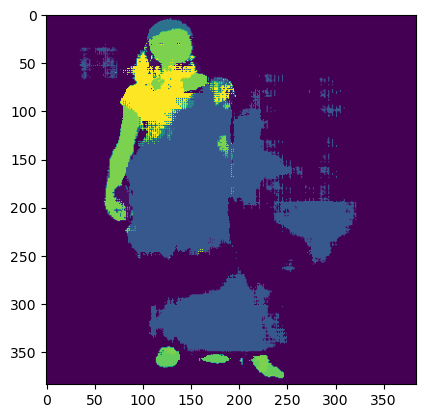

In [13]:
# Display the predicted mask
plt.imshow(predicted_mask, cmap='viridis')  # Use 'viridis' or another colormap for multi-class
plt.show()

In [14]:
# Precicted classes
np.unique(predicted_mask)

array([ 0,  1,  2,  4,  5, 10, 14, 19, 26, 39, 41, 42, 48, 49, 51])

## 4. Get Bounding Boxes of classes

In [15]:
# Create a function to get the bounding boxes
def get_class_bounding_boxes(mask, num_classes):
    """
    Find bounding boxes for each class in the segmentation mask.
    
    Args:
    mask: np.array, shape (height, width), contains class labels for each pixel.
    num_classes: int, number of classes.
    
    Returns:
    bounding_boxes: dict, where keys are class indices and values are bounding boxes (x_min, y_min, x_max, y_max).
    """
    bounding_boxes = {}
    
    for class_idx in range(num_classes):
        # Find all pixels belonging to the current class
        class_mask = (mask == class_idx).astype(np.uint8)

        # Find contours for the class mask
        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the bounding box around the largest contour
            x_min, y_min, x_max, y_max = np.inf, np.inf, -np.inf, -np.inf
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x + w), max(y_max, y + h)
            
            bounding_boxes[class_idx] = (x_min, y_min, x_max, y_max)

    return bounding_boxes

In [16]:
num_classes = predicted_mask.max() + 1  
bounding_boxes = get_class_bounding_boxes(predicted_mask, num_classes)

# bounding_boxes will now contain the bounding box for each class
for class_idx, box in bounding_boxes.items():
    print(f"Class {class_idx}: Bounding Box {box}")

Class 0: Bounding Box (0, 0, 384, 384)
Class 1: Bounding Box (71, 30, 161, 205)
Class 2: Bounding Box (60, 23, 196, 354)
Class 4: Bounding Box (112, 61, 113, 62)
Class 5: Bounding Box (105, 55, 130, 78)
Class 10: Bounding Box (187, 350, 192, 351)
Class 14: Bounding Box (35, 31, 322, 354)
Class 19: Bounding Box (105, 4, 153, 27)
Class 26: Bounding Box (80, 56, 189, 123)
Class 39: Bounding Box (114, 348, 247, 378)
Class 41: Bounding Box (60, 15, 238, 376)
Class 42: Bounding Box (64, 100, 195, 227)
Class 48: Bounding Box (128, 89, 163, 253)
Class 49: Bounding Box (126, 120, 131, 131)
Class 51: Bounding Box (72, 30, 197, 253)


### 5. Get Labels from Classes

In [17]:
# Import labels from csv file
labels = pd.read_csv('Resources/labels/labels.csv')
# Drop unamed column
labels.drop('Unnamed: 0', axis=1, inplace=True)
# Display labels
labels.head()


,label_list,category
0,NaN,other
1,accessories,other
2,bag,other
3,belt,other
4,blazer,upper


In [18]:
labels['category'].unique()

array(['other', 'upper', 'shoes', 'head', 'lower'], dtype=object)

In [19]:
# Get label names from bounding_boxes keys
image_labels = labels.iloc[list(bounding_boxes.keys())].reset_index(drop=True)
image_labels

,label_list,category
0,NaN,other
1,accessories,other
2,bag,other
3,blazer,upper
4,blouse,upper
5,cape,upper
6,dress,upper
7,hair,other
8,jumper,upper
9,shoes,shoes


### 6. Create images from the bounding boxes

In [20]:
images=[]
pixels = []
# Loop through bounding boxes, crop images and save them to disk
for class_idx, box in bounding_boxes.items():
    class_name = labels.iloc[class_idx]['label_list']
    temp_img = img.crop(box)
    images.append(temp_img)
    pixels.append(temp_img.size[0]*temp_img.size[1])

In [21]:
image_labels['pixels'] = pixels
image_labels = image_labels.sort_values(by='pixels', ascending=False)
image_labels

,label_list,category,pixels
0,NaN,other,147456
6,dress,upper,92701
10,skin,other,64258
2,bag,other,45016
14,t-shirt,upper,27875
11,skirt,lower,16637
1,accessories,other,15750
8,jumper,upper,7303
12,sweater,upper,5740
9,shoes,shoes,3990


In [22]:
def get_middle_index(df):
    if len(df)%2 == 0:
        return int(len(df)/2)-1
    else:
        return int((len(df) - 1)/2)

In [23]:
head = image_labels[(image_labels['category'] == 'head') & (image_labels['pixels'] > 3000)]
if len(head) >= 1:
    head = head.iloc[get_middle_index(head)]
    images[head.name].save(f'Output/images/head.png')
else:
    Image.new('RGB', (10, 10)).save(f'Output/images/head.png')

In [24]:
upper = image_labels[(image_labels['category'] == 'upper') & (image_labels['pixels'] > 3000)]
if len(upper) >= 1:
    upper = upper.iloc[get_middle_index(upper)]
    images[upper.name].save(f'Output/images/upper.png')
else:
    Image.new('RGB', (10, 10)).save(f'Output/images/upper.png')

In [25]:
lower = image_labels[(image_labels['category'] == 'lower') & (image_labels['pixels'] > 3000)]
if len(lower) >= 1:
    lower = lower.iloc[get_middle_index(lower)]
    images[lower.name].save(f'Output/images/lower.png')
else:
    Image.new('RGB', (10, 10)).save(f'Output/images/lower.png')

In [26]:
shoes = image_labels[(image_labels['category'] == 'shoes') & (image_labels['pixels'] > 3000)]
if len(shoes) >= 1:
    shoes = shoes.iloc[get_middle_index(shoes)]
    images[shoes.name].save(f'Output/images/shoes.png')
else:
    Image.new('RGB', (10, 10)).save(f'Output/images/shoes.png')

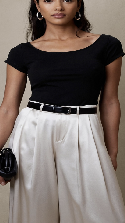

In [27]:
images[upper.name]

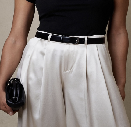

In [28]:
images[lower.name]

In [29]:
images[shoes.name]